In [1]:
import errno
import torch
import numpy as np
from glob import glob
from PIL import Image
import torch.nn as nn
import torchvision.transforms as transforms

import torch.nn.functional as F
from loguru import logger as lgr
from matplotlib import pyplot as plt
import os
import argparse
from gritlm import GritLM   # pip install gritlm

from models.get_model import get_model, SINREmbeddingModel

import cv2

/work/pi_smaji_umass_edu/rdaroya/conda_env/sat_eval/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define necessary variables here
sample_imgs_dir = "sample_data"
ckpt_path = "vitb16-imagenet-bnfc.pth"

satellite_encoder_ckpt = None   # only use this for non-ImageNet pre-trained or non-randomly initialized models

# Helper functions

In [3]:
def extract_grit_token(model, text:str):
    def gritlm_instruction(instruction):
        return "<|user|>\n" + instruction + "\n<|embed|>\n" if instruction else "<|embed|>\n"
    d_rep = model.encode([text], instruction=gritlm_instruction(""))
    d_rep = torch.from_numpy(d_rep)
    return d_rep

def plot_fps(fps, subplot_titles=None, overall_title=None):
    if subplot_titles is not None:
        assert len(fps)==len(subplot_titles)
    # num_cols = min(5, len(fps))
    # num_rows = int(np.ceil(len(fps)/num_cols))
    num_rows = min(5, len(fps))
    num_cols = int(np.ceil(len(fps)/num_rows))
    
    print(num_rows, num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*3, num_rows*3), gridspec_kw = {'wspace':0, 'hspace':0})
    for idx, actual_fp in enumerate(fps):
        row_idx = idx//num_cols
        col_idx = int(idx%num_cols)

        img = cv2.imread(actual_fp)[:,:,::-1]
        if (num_rows > 1) and (num_cols > 1):
            axs[row_idx, col_idx].imshow(img)
            axs[row_idx, col_idx].set_yticks([])
            axs[row_idx, col_idx].set_xticks([])
            if subplot_titles is not None:
                axs[row_idx, col_idx].set_title(subplot_titles[idx])
        else:
            actual_idx = col_idx
            if num_rows > 1:
                actual_idx = row_idx
            axs[actual_idx].imshow(img)
            axs[actual_idx].set_yticks([])
            axs[actual_idx].set_xticks([])
            if subplot_titles is not None:
                axs[col_idx].set_title(subplot_titles[idx])
    idx += 1
    while idx<(num_cols*num_rows):
        row_idx = idx//num_cols
        col_idx = int(idx%num_cols)
        if (num_rows > 1) and (num_cols > 1):
            axs[row_idx, col_idx].axis("off")
            axs[row_idx, col_idx].set_yticks([])
            axs[row_idx, col_idx].set_xticks([])
        else:
            actual_idx = col_idx
            if num_rows > 1:
                actual_idx = row_idx
            axs[actual_idx].axis("off")
            axs[actual_idx].set_yticks([])
            axs[actual_idx].set_xticks([])
        idx += 1
    if overall_title is not None:
        plt.suptitle(overall_title)
    fig.tight_layout()
    # plt.subplots_adjust(wspace=0, hspace=0)
    # fig.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

    return fig

class LinearforCLIP(nn.Module): # TODO: fix this implementation
    def __init__(self, opt, embed_dim=256, normalize=False):
        super(LinearforCLIP, self).__init__()
        in_dim = 512
        self.head = nn.Linear(in_dim, embed_dim, bias=False)
        self.normalize = normalize

    def forward(self, text_emb):
        embed = self.head(text_emb)
        if self.normalize:
            embed = F.normalize(embed, dim=-1)
        return embed

class LinearforText(nn.Module): # TODO: fix this implementation
    def __init__(self, opt, embed_dim=256, normalize=False):
        super(LinearforText, self).__init__()
        in_dim = 4096
        self.head = nn.Linear(in_dim, embed_dim, bias=False)
        self.normalize = normalize

    def forward(self, text_emb):
        embed = self.head(text_emb)
        if self.normalize:
            embed = F.normalize(embed, dim=-1)

        return embed

class SINRwithLinear(nn.Module):
    def __init__(self, sinr_train_params, opt, embed_dim=256, normalize=False):
        super(SINRwithLinear, self).__init__()
        self.sinr = SINREmbeddingModel(sinr_train_params, return_logits=False)
        in_dim = 256
        self.head = nn.Linear(in_dim, embed_dim, bias=False)
        self.normalize = normalize

    def forward(self, lonlat):
        sinr_feat = self.sinr(lonlat)
        embed = self.head(sinr_feat)
        if self.normalize:
            embed = F.normalize(embed, dim=-1)
        return sinr_feat, embed

# Load models

In [4]:
ckpt = torch.load(ckpt_path)
ckpt_name = ckpt_path.split("/")[-1].split(".")[0]
lgr.debug(f"ckpt loaded from epoch: {ckpt['epoch']}")

opt = ckpt["opt"]
lgr.debug(f"Checkpoint's opt: {opt}")
opt_num_outputs = opt.__dict__.get("num_outputs") or opt.__dict__.get("common_embed_dim")


if satellite_encoder_ckpt is not None:
    satellite_model = get_model(opt.satellite_encoder, opt.satellite_head, opt_num_outputs, 
        pretrained=True, is_residual=False, encoder_ckpt_path=satellite_encoder_ckpt,
        normalize=False,
    )
    satellite_model.num_feats = satellite_model.backbone.fc.in_features
    satellite_model.backbone.fc = nn.Identity()
    
    lgr.debug(f"Replaced fc with Identity since using diff head")
    lgr.debug(f"Using other pretrained encoder from {satellite_encoder_ckpt}")
else:
    satellite_model = get_model(opt.satellite_encoder, opt.satellite_head, opt_num_outputs, is_residual=False, normalize=False,)
    lgr.debug("Using imagenet1K pretrained encoder")
        
new_ckpt = {k.split("module.")[-1]:v for k,v in ckpt["satellite_state_dict"].items()}
ckpt["satellite_state_dict"] = new_ckpt
new_sinr_ckpt = {k.split("module.")[-1]:v for k,v in ckpt["sinr_state_dict"].items()}
ckpt["sinr_state_dict"] = new_sinr_ckpt

lgr.debug(f"Loading text embedding model (Linear)")
text_emb_model = LinearforText(opt, embed_dim=opt.common_embed_dim, normalize=False,)
new_text_ckpt = {k.split("module.")[-1]:v for k,v in ckpt["text_emb_model"].items()}
tmp = text_emb_model.load_state_dict(new_text_ckpt)
lgr.debug(f"Loaded text_emb_model state dict: {tmp}")

tmp = satellite_model.load_state_dict(ckpt["satellite_state_dict"])
lgr.debug(f"Loading satellite_model state dict: {tmp}")


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

satellite_model.to(device)

satellite_model.eval()
text_emb_model.eval()


os.environ["TOKENIZERS_PARALLELISM"] = "false"
grit = GritLM("GritLM/GritLM-7B", torch_dtype="auto", mode="embedding")
print()

/tmp/ipykernel_1800571/696505522.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path)
2025-05-30 12:59:38.960 | DEBUG    | __main__:<module>:3 - 

Created GritLM: torch.bfloat16 dtype, mean pool, embedding mode, bbcc attn



# Process data

In [5]:

lgr.debug(f"Computing embeddings for {sample_imgs_dir}.")

if (opt.satellite_encoder == "vitb16") or (opt.satellite_encoder == "vitl16"):
    final_size = 224
data_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize(size=(final_size,final_size)),])

all_images = []
all_sat_fp = []
for fp in glob(os.path.join(sample_imgs_dir, "*.png")):
    all_sat_fp.append(fp)
    image = Image.open(fp)  # size: (512,512)
    image = data_transforms(image)
    if (torch.max(image)-torch.min(image)):
        image = image - torch.min(image)
        image = image / torch.maximum(torch.max(image),torch.tensor(1))
    else:
        image = torch.zeros_like(image)
    all_images.append(image.unsqueeze(0))

2025-05-30 12:59:43.583 | DEBUG    | __main__:<module>:1 - Computing embeddings for sample_data.


# Predict embeddings on images

In [6]:

with torch.no_grad():
    all_sat_model_text_pred, all_sat_model_sinr_pred, all_sat_model_img_pred =[], [], []
    for imgs in all_images:
        imgs = imgs.to(device, non_blocking=True)
        
        feats, all_preds = satellite_model(imgs)
        sat_model_text_pred, sat_model_sinr_pred, sat_model_img_pred = all_preds    # embeddings for each of text, location, image
        all_sat_model_text_pred.append(sat_model_text_pred)
        all_sat_model_sinr_pred.append(sat_model_sinr_pred)
        all_sat_model_img_pred.append(sat_model_img_pred)

    all_sat_model_text_pred = torch.cat(all_sat_model_text_pred, dim=0)
    all_sat_model_sinr_pred = torch.cat(all_sat_model_sinr_pred, dim=0)
    all_sat_model_img_pred = torch.cat(all_sat_model_img_pred, dim=0)
    lgr.debug(f"all_sat_model_text_pred: {all_sat_model_text_pred.shape}")
    lgr.debug(f"all_sat_model_sinr_pred: {all_sat_model_sinr_pred.shape}")
    lgr.debug(f"all_sat_model_img_pred: {all_sat_model_img_pred.shape}")
    all_embeddings = {
        "sat_model_text_pred": all_sat_model_text_pred,
        "sat_model_sinr_pred": all_sat_model_sinr_pred,
        "sat_model_img_pred": all_sat_model_img_pred,
        "sat_fp": all_sat_fp,
    }

sat_text_pred = all_embeddings["sat_model_text_pred"]
sat_sinr_pred = all_embeddings["sat_model_sinr_pred"]
sat_img_pred = all_embeddings["sat_model_img_pred"]
sat_fps = all_embeddings["sat_fp"]
lgr.debug(f"sat_text_pred: {sat_text_pred.shape}")  # (N, 256)
lgr.debug(f"sat_sinr_pred: {sat_sinr_pred.shape}")  # (N, 256)
lgr.debug(f"sat_img_pred: {sat_img_pred.shape}")  # (N, 256)
lgr.debug(f"sat_fps: {len(sat_fps)}")  # N



2025-05-30 12:59:44.825 | DEBUG    | __main__:<module>:15 - all_sat_model_text_pred: torch.Size([19, 256])
2025-05-30 12:59:44.826 | DEBUG    | __main__:<module>:16 - all_sat_model_sinr_pred: torch.Size([19, 256])
2025-05-30 12:59:44.826 | DEBUG    | __main__:<module>:17 - all_sat_model_img_pred: torch.Size([19, 256])
2025-05-30 12:59:44.827 | DEBUG    | __main__:<module>:29 - sat_text_pred: torch.Size([19, 256])
2025-05-30 12:59:44.827 | DEBUG    | __main__:<module>:30 - sat_sinr_pred: torch.Size([19, 256])
2025-05-30 12:59:44.828 | DEBUG    | __main__:<module>:31 - sat_img_pred: torch.Size([19, 256])
2025-05-30 12:59:44.828 | DEBUG    | __main__:<module>:32 - sat_fps: 19


In [7]:

def process_text_input(
    grit, text_input, sat_fps, text_emb_model,
    sat_text_pred, num_unique_fps=10, to_print_fps=False,
):
    with torch.no_grad():
        text_emb = extract_grit_token(grit, text_input)
        proj_text_emb = text_emb_model(text_emb).to(device, non_blocking=True)
    sat_pred = sat_text_pred
    lgr.debug(f"proj_text_emb: {proj_text_emb.shape}")

    lgr.debug(f"Finding top 10 most similar satellite images")
    init_logit_scale = np.log(10)
    logit_scale = nn.Parameter(torch.ones([]) * init_logit_scale)
    

    with torch.no_grad():
        logits_per_image = logit_scale * sat_pred @ proj_text_emb.T

        idxval_top_10 = torch.topk(logits_per_image, 10, dim=0)
        idx_top_10 = idxval_top_10.indices.flatten()

    top_sat_fps = []
    for idx in idx_top_10:
        top_sat_fps.append(sat_fps[idx])
    unique_fps = np.unique(top_sat_fps)[:num_unique_fps]
    top_unique_fps = unique_fps[:num_unique_fps]
    if to_print_fps:
        lgr.debug(f"unique top_sat_fps: {top_unique_fps}")
        lgr.debug(f"len(top_unique_fps): {len(top_unique_fps)}")
    return top_unique_fps

2025-05-30 13:00:41.160 | DEBUG    | __main__:process_text_input:9 - proj_text_emb: torch.Size([1, 256])
2025-05-30 13:00:41.161 | DEBUG    | __main__:process_text_input:11 - Finding top 10 most similar satellite images


3 1



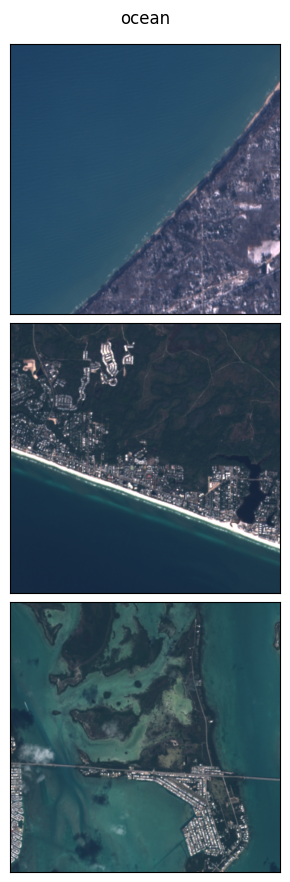

In [ ]:
# Display the top 3 matches for given text input
text_input = "ocean"
top_unique_fps = process_text_input(
    grit, text_input, sat_fps, text_emb_model,
    sat_text_pred, num_unique_fps=3, to_print_fps=False,
)

plot_fps(
    top_unique_fps, 
    overall_title=text_input,
)
print()